In [78]:
import os
import sys
import uproot
import uproot_methods
import numpy as np
import time

# Nick needs a hack to get the right matplotlib version
sys.path.insert(0,'/home/users/{}/.local/lib/python2.7/site-packages/'.format(os.getenv("USER")))
import matplotlib as mpl
import matplotlib.pyplot as plt
print mpl.__version__

import pandas as pd

# jupyter nbextension install --py  widgetsnbextension --user
# jupyter nbextension enable --py  widgetsnbextension --user
from tqdm import tqdm, tqdm_notebook


from XRootD import client

import requests
# pip install requests-cache (or requests_cache?)
import requests_cache

import concurrent.futures

# keep at end or else syspath hack is bypassed
%matplotlib inline

2.2.0


### Make some caches and workers first

#### Worker pools
Two worker pools returning futures to share work in parallel. We wait for full sets of futures before continuing.
* One to **read** branches (fed into uproot)
* One to **calculate** with the read numpy arrays (use manually)

#### Caches
* Disk cache of HTTP **requests** (minimize DIS/DBS queries)
* Memory cache of read arrays from uproot

In [79]:
read_executor = concurrent.futures.ThreadPoolExecutor(24)
calc_executor = concurrent.futures.ThreadPoolExecutor(16)

array_cache = uproot.cache.ThreadSafeArrayCache(4*1024**3)
requests_cache.install_cache("test",backend="sqlite")

### XRootD stuff

Use python bindings to download files with xrootd. I don't bother using uproot to read over xrootd because of network failures around the world. I just download the files in one go (sub-TB) and use those.

I like progress bars, so make a custom callback class.

In [80]:
class MyCopyProgressHandler(client.utils.CopyProgressHandler):
    def begin(self, jobId, total, source, target):
        self.t = None
        self.cancel = False

    def end(self, jobId, result):
        if self.t is not None:
            self.t.close()
#         if not result.get("status",{}).get("ok",False):
#             print "Status not ok: {}".format(result)

    def update(self, jobId, processed, total):
        if self.t is None:
            self.t = tqdm_notebook(total=total,unit="B",unit_scale=True)
            self.t.set_postfix(jobid=jobId)
            self.current = 0
            self.t.update(processed-self.current)
        self.current = processed

    def should_cancel(jobId):
        return self.cancel

### Dataset stuff

Make a `Dataset` class which takes a dataset name or directory name, as well as things like a nickname (`shortname`), `year`, `xsec`, and `max_events`. Based on the dataset name, `year` is automatically filled.

In [81]:
class Dataset(object):
    def __init__(self,dataset=None,shortname=None,year=-1,xsec=0.0,directory=None,max_events=-1):
        self.dataset = str(dataset)
        self.shortname = str(shortname)
        self.year = int(year)
        self.directory = str(directory)
        self.xsec = float(xsec)
        self.max_events = int(max_events)
        
        self.local_filenames = []
        
        self.detect_year()
    
    def detect_year(self):
        search = self.dataset if self.dataset else self.directory
        if self.year < 0:
            if ("Spring16" in search) or ("Summer16" in search): self.year = 2016
            elif "Fall17" in search: self.year = 2017
            elif "Autumn18" in search: self.year = 2018
            else: print "WARNING: Can't detect year of {}".format(search)
                
    def get_dbs_files(self):
        r = requests.get("http://uaf-1.t2.ucsd.edu/~namin/dis/handler.py", params=dict(query=self.dataset,type="files",short=""))
        df = pd.DataFrame(r.json()["response"]["payload"])
        df = df.sort_values(["name"])
        df["cumul_nevents"] = np.cumsum(df["nevents"])
        if self.max_events > 0:
            df = df[(df["cumul_nevents"] <= self.max_events) | (df["cumul_nevents"] == df["nevents"])]
        return df
    
    def get_local_filenames(self):
        return self.local_filenames
    
    def get_remote_filenames(self):
        return self.get_dbs_files()["name"].values

    def download_files(self, dummy=False):
        nicedir = "data/"+("__".join(self.dataset.split("/")[1:3]))
        os.system("mkdir -p "+nicedir)
        if not dummy:
            process = client.CopyProcess()
        files = self.get_dbs_files()
        self.local_filenames = []
        for fname in files["name"].values:
#             source = "root://cmsxrootd.fnal.gov/{}".format(fname)
            source = "root://cms-xrd-global.cern.ch/{}".format(fname)
            dest = "{}/{}".format(os.path.abspath(nicedir),fname.rsplit("/",1)[-1])
            self.local_filenames.append(dest)
            if os.path.exists(dest): 
                continue
            if not dummy:
                print "Downloading {} -> {}".format(source,dest)
                process.add_job(source, dest,
                    inittimeout=30,
                    sourcelimit=4,
                    )
            else:
                print "Would download {} -> {}".format(source,dest)
        if not dummy:
            handler = MyCopyProgressHandler();
            process.prepare();
            process.run(handler);
        self.local_filenames = filter(os.path.exists, self.local_filenames)
        print "Done! ({} files, {:.1f}GB, {} events)".format(len(files),files["sizeGB"].sum(),files["nevents"].sum())

#### Quick example

Get a dataset and fetch only enough files to keep event count below 50k (if the first file is larger than this, we will fetch just the first file).

In [82]:
ds = Dataset(
    dataset="/THW_5f_Hincl_13TeV_madgraph_pythia8/RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/NANOAODSIM",
    max_events=50e3,
       )
ds.get_dbs_files()

,name,nevents,sizeGB,cumul_nevents
32,/store/mc/RunIIAutumn18NanoAODv4/THW_5f_Hincl_...,5800,0.02,5800
45,/store/mc/RunIIAutumn18NanoAODv4/THW_5f_Hincl_...,10600,0.03,16400
73,/store/mc/RunIIAutumn18NanoAODv4/THW_5f_Hincl_...,14000,0.03,30400
33,/store/mc/RunIIAutumn18NanoAODv4/THW_5f_Hincl_...,16400,0.04,46800


Now download the files locally and print out the filenames

In [83]:
ds.download_files()
print ds.get_local_filenames()

Done! (4 files, 0.1GB, 46800 events)
['/home/users/namin/sandbox/th/data/THW_5f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/1C4A9E49-D469-854A-839B-BE60998D6A16.root', '/home/users/namin/sandbox/th/data/THW_5f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/3B0C4E24-7CC1-694E-8606-D127A840295D.root', '/home/users/namin/sandbox/th/data/THW_5f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/44AA1784-4E9F-3046-AA9B-5C3F1DE54B70.root', '/home/users/namin/sandbox/th/data/THW_5f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/51B4EEB7-594F-684E-AECA-F78DACB6108C.root']


#### Define many datasets
Collect NANOAOD dataset names (one per year). Turn into dataframe and assign proper `xsec` column.
I make a `shortname` based on the dataset name before the first underscore.
For prototyping, I drop all but the 2018 `Autumn18` samples.

In [84]:
dataset_names = [
    "/THQ_4f_Hincl_13TeV_madgraph_pythia8/RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/NANOAODSIM",
    "/THQ_4f_Hincl_13TeV_madgraph_pythia8/RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/NANOAODSIM",
    "/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/RunIISummer16NanoAODv4-PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/NANOAODSIM",
    "/THW_5f_Hincl_13TeV_madgraph_pythia8/RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/NANOAODSIM",
    "/THW_5f_Hincl_13TeV_madgraph_pythia8/RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/NANOAODSIM",
    "/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/RunIISummer16NanoAODv4-PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/NANOAODSIM",
    "/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/NANOAODSIM",
    "/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/NANOAODSIM",
    "/TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/RunIISummer16NanoAODv4-PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/NANOAODSIM",
    "/ttWJets_13TeV_madgraphMLM/RunIISummer16NanoAODv4-Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/NANOAODSIM",
    "/ttWJets_TuneCP5_13TeV_madgraphMLM_pythia8/RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/NANOAODSIM",
    "/ttWJets_TuneCP5_13TeV_madgraphMLM_pythia8/RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16_ext1-v1/NANOAODSIM",
    "/ttZJets_13TeV_madgraphMLM-pythia8/RunIISummer16NanoAODv4-PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/NANOAODSIM",
    "/ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8/RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/NANOAODSIM",
    "/ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8/RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16_ext1-v1/NANOAODSIM",
    "/ttHTobb_M125_13TeV_powheg_pythia8/RunIISummer16NanoAODv4-PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/NANOAODSIM",
    "/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_new_pmx_102X_mc2017_realistic_v6-v1/NANOAODSIM",
    "/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAOD-102X_upgrade2018_realistic_v15-v3/NANOAODSIM",
    "/ttHToNonbb_M125_TuneCUETP8M2_ttHtranche3_13TeV-powheg-pythia8/RunIISummer16NanoAODv4-PUMoriond17_Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/NANOAODSIM",
    "/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/NANOAODSIM",
    "/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8/RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_new_pmx_102X_mc2017_realistic_v6-v1/NANOAODSIM",
]
df_datasets = pd.DataFrame(dataset_names,columns=["name"]).reset_index(drop=True)
df_datasets["shortname"] = df_datasets["name"].str[1:].str.split("_").str[0]
df_datasets["xsec"] = 1.
names = df_datasets["name"].str
df_datasets.loc[names.contains("THQ"),["xsec"]] = 0.0748 # https://arxiv.org/pdf/1504.00611.pdf
df_datasets.loc[names.contains("THW"),["xsec"]] = 0.016*0.0748/0.0718 # eq 16/10 of https://arxiv.org/pdf/1211.0499.pdf
df_datasets.loc[names.contains("ttHTobb"),["xsec"]] = 0.2044
df_datasets.loc[names.contains("ttHToNonbb"),["xsec"]] = 0.2710
df_datasets.loc[names.contains("ttZ"),["xsec"]] = 0.840
df_datasets.loc[names.contains("ttW"),["xsec"]] = 0.610
df_datasets.loc[names.contains("TTJets"),["xsec"]] = 831.8
df_datasets = df_datasets[names.contains("Autumn18")]
df_datasets

,name,shortname,xsec
1,/THQ_4f_Hincl_13TeV_madgraph_pythia8/RunIIAutu...,THQ,0.074800
4,/THW_5f_Hincl_13TeV_madgraph_pythia8/RunIIAutu...,THW,0.016669
7,/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/RunI...,TTJets,831.800000
11,/ttWJets_TuneCP5_13TeV_madgraphMLM_pythia8/Run...,ttWJets,0.610000
14,/ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8/Run...,ttZJets,0.840000
17,/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/Run...,ttHTobb,0.204400
19,/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8/...,ttHToNonbb,0.271000


Make a list of `Dataset` objects with 500k events and download all the files.

In [85]:
dfs = {}
datasets = []
for irow,row in df_datasets.iterrows():
    ds = Dataset(
        dataset=row["name"],
        xsec=row["xsec"],
        shortname=row["shortname"],
        max_events=500e3,
    )
#     ds.download_files(dummy=True)
    ds.download_files()
    datasets.append(ds)

Done! (4 files, 0.7GB, 419998 events)
Done! (33 files, 1.1GB, 487399 events)
Done! (1 files, 2.3GB, 1423357 events)
Done! (1 files, 2.3GB, 1182907 events)
Done! (1 files, 2.0GB, 1010311 events)
Done! (7 files, 1.0GB, 462000 events)
Done! (1 files, 0.9GB, 440999 events)


Here's a basic example of how we iterate over the files in chunks to get numpy arrays of MET pT (inside of a dict)

In [86]:
ds = datasets[0]
for branches in uproot.iterate(ds.get_local_filenames(),"Events",["MET_pt"],entrysteps=100000,outputtype=dict):
    met = branches["MET_pt"]
    print met, met.mean()

[ 55.341545  23.05404  149.67633  ...  22.737165  42.543575  72.98994 ] 77.951355
[130.88202   34.507053  88.51431  ...  12.941888 152.76976  103.06894 ] 77.57716
[  9.239309  97.08011   82.79198  ... 448.3188     4.415573 140.75223 ] 77.89722
[ 89.10843   87.608986  81.30046  ... 100.80799   88.94694   78.58564 ] 77.71432
[59.55604  61.66984  56.470455 ... 34.86809  71.84042  80.711685] 77.342316
[95.26613  70.95838  15.845738 ... 88.93492  47.52549  72.03522 ] 77.48342


### Make things more complicated

One function which gets a p4 array (with other info attached, like btag discriminator, ID, etc) given "Jet", "Electron", or "Muon".

In [87]:
def get_object(branches, x, year=2016):
    # filter(lambda x:"Electron_" in x,t.keys())
    # filter(lambda x:"Muon_" in x,t.keys())
    # filter(lambda x:"MET_" in x,t.keys())
    pt,eta,phi,mass = branches[x+"_pt"],branches[x+"_eta"],branches[x+"_phi"],branches[x+"_mass"]
    obj = uproot_methods.TLorentzVectorArray.from_ptetaphim(pt,eta,phi,mass)
    if x == "Jet":
        bwp = {2016: 0.6324, 2017: 0.4941, 2018: 0.4184}[year]
        obj["isbtag"] = (branches[x+"_btagDeepB"] > bwp)
        obj["isgood"] = ((branches[x+"_jetId"] >> 2) > 0) & (branches[x+"_cleanmask"] > 0) & (np.abs(obj.eta) < 2.5) & (obj.pt > 25.)
    elif x == "Electron":
        obj["istight"] = (branches[x+"_mvaTTH"]) > 0.75
        obj["charge"] = (branches[x+"_charge"])
    elif x == "Muon":
        obj["istight"] = (branches[x+"_mvaTTH"]) > 0.75
        obj["charge"] = (branches[x+"_charge"])
    return obj

Make another function that, given a dict of branches (actually a future of branches), calculates and returns a dataframe of many event-level variables.

In [88]:
def get_df_from_branches(branches,xsec,year):
    # We await the result of the `branches` future, so this next line blocks.
    branches = branches()
    
    jets = get_object(branches,"Jet",year=year)
    nevents = len(jets)
    jets = jets[jets["isgood"]]
    btags = jets[jets["isbtag"]]
    electrons = get_object(branches,"Electron")
    electrons = electrons[electrons["istight"]]
    muons = get_object(branches,"Muon")
    muons = muons[muons["istight"]]

    ht = jets.pt.sum()
    htb = btags.pt.sum()

    bb = btags.distincts()
    mbb = (bb.i0 + bb.i1).mass
    bestmbb = mbb[np.abs(mbb-125.).argmin()].min()
    bestmbb[~np.isfinite(bestmbb)] = -1.
    # -1 for events that don't have 2 btags at least

    jj = jets.distincts()
    maxmjj = (jj.i0+jj.i1).mass.max()

    ee = electrons.distincts()
    maxmee = (ee.i0+ee.i1).mass.max()
    mm = muons.distincts()
    maxmmm = (mm.i0+mm.i1).mass.max()
    maxmll = np.maximum(maxmee,maxmmm)
    maxmll[~np.isfinite(maxmll)] = -1.

    forwardeta = np.abs(jets.eta).max()
    ptjet1 = jets.pt.max()
    ptjet2 = jets.pt[jets.pt != jets.pt.max()].max()
    ptjet1[~np.isfinite(ptjet1)] = -1.
    ptjet2[~np.isfinite(ptjet2)] = -1.

    met,metphi = branches["MET_pt"],branches["MET_phi"]

    nleps = (electrons.counts + muons.counts)
    njets = jets.counts
    nbtags = btags.counts

    ptlep1 = np.maximum(
        (electrons.pt).max(),
        (muons.pt).max(),
    )
    ptlep1[~np.isfinite(ptlep1)] = -1
    dphimetlep1 = np.minimum(
        ((electrons.phi - metphi + np.pi)%(2*np.pi)-np.pi).min(),
        ((muons.phi - metphi + np.pi)%(2*np.pi)-np.pi).min()
    )
    dphimetlep1[~np.isfinite(dphimetlep1)] = -999.
    mtlep1 = ((2.*ptlep1*met)*(1-np.cos(dphimetlep1)))**.5
    mtlep1[~np.isfinite(mtlep1)] = -1

    lumi = {2016: 35.9, 2017: 41.5, 2018: 59.7}[year]
    weight = np.ones(len(met))*lumi*xsec/nevents*1000.

    df = pd.DataFrame(
        np.c_[
            nleps,njets,nbtags,
            bestmbb,
            met,dphimetlep1,
            ptlep1,mtlep1,
            ptjet1,ptjet2,
            maxmjj,
            maxmll,
            ht,htb,
            forwardeta,
            weight,
        ],columns=[
            "nleps","njets","nbtags",
            "bestmbb",
            "met","dphimetlep1",
            "ptlep1","mtlep1",
            "ptjet1","ptjet2",
            "maxmjj",
            "maxmll",
            "ht","htb",
            "forwardeta",
            "weight",
        ])
    return df

Main function: get a dataframe given a list of file names. We read using a `concurrent.futures` executor to read branches in parallel. The futures are then put into a list and we submit more futures to calculate using the above functions.

In [89]:
def get_df(fpatt,xsec=1,year=2016):
    t0 = time.time()
#     pbar = tqdm_notebook(total=300000, unit_scale=True, unit="evt")
    futures_dfs = []
    for entrystart,entrystop,branches in uproot.iterate(fpatt,"Events",
                        [
                            "Jet_pt", "Jet_eta", "Jet_phi","Jet_mass","Jet_btagDeepB","Jet_jetId","Jet_cleanmask",
                            "Electron_pt", "Electron_eta", "Electron_phi","Electron_mass","Electron_mvaTTH","Electron_charge",
                            "Muon_pt", "Muon_eta", "Muon_phi","Muon_mass","Muon_mvaTTH","Muon_charge",
                            "MET_pt", "MET_phi",
                        ],
                       outputtype=dict,
                       entrysteps=300000,
                       cache=array_cache,
                       executor=read_executor,
                       blocking=False,
                                   reportentries=True,
                       ):
        print "Got future for entry {}->{}".format(entrystart,entrystop)
        futures_dfs.append(
            calc_executor.submit(get_df_from_branches,branches,xsec,year)
        )
#     pbar.close()
    print "Waiting for {} futures (including calculations)".format(len(futures_dfs))
    df = pd.concat([fut.result() for fut in futures_dfs])
    t1 = time.time()
    print "{} events in {:.1f}s ({:.1f}kHz)".format(len(df),t1-t0,0.001*len(df)/(t1-t0))
    return df

# get_df("data/THQ_4f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/09293AA4-3F21-484C-A456-A094E96EC962.root",)

Loop through the `Dataset` objects and make a dict of dataframes

In [90]:
dfs = {}
for ds in datasets:
    print "### {} ({}) ###".format(ds.shortname, ds.year)
    dfs[ds.shortname] = get_df(ds.get_local_filenames(),xsec=ds.xsec,year=ds.year)

### THQ (2018) ###
Got future for entry 0->101999
Got future for entry 101999->149999
Got future for entry 149999->329998
Got future for entry 329998->419998
Waiting for 4 futures (including calculations)


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-elfike2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


419998 events in 28.6s (14.7kHz)
### THW (2018) ###
Got future for entry 0->5800
Got future for entry 5800->16400
Got future for entry 16400->30400
Got future for entry 30400->46800
Got future for entry 46800->52200
Got future for entry 52200->55900
Got future for entry 55900->75000
Got future for entry 75000->77200
Got future for entry 77200->114000
Got future for entry 114000->128600
Got future for entry 128600->131000
Got future for entry 131000->156700
Got future for entry 156700->158500
Got future for entry 158500->219600
Got future for entry 219600->225600
Got future for entry 225600->227400
Got future for entry 227400->269500
Got future for entry 269500->270100
Got future for entry 270100->283200
Got future for entry 283200->292800
Got future for entry 292800->341100
Got future for entry 341100->344100
Got future for entry 344100->361200
Got future for entry 361200->377600
Got future for entry 377600->385800
Got future for entry 385800->398600
Got future for entry 398600->408500

This is what one of the dataframes looks like (for tHq)

In [91]:
dfs["THQ"]

,nleps,njets,nbtags,bestmbb,met,dphimetlep1,ptlep1,mtlep1,ptjet1,ptjet2,maxmjj,maxmll,ht,htb,forwardeta,weight
0,1.0,1.0,1.0,-1.000000,55.341545,-2.758057,58.913792,112.106064,152.000000,-1.000000,-inf,-1.000000,152.000000,152.000000,0.650024,0.043780
1,0.0,4.0,3.0,102.638809,23.054041,-999.000000,-1.000000,-1.000000,235.124985,141.375000,447.690765,-1.000000,566.562500,429.062500,1.673096,0.043780
2,0.0,3.0,1.0,-1.000000,149.676331,-999.000000,-1.000000,-1.000000,136.875000,32.031250,141.509033,-1.000000,197.656250,136.875000,1.525879,0.043780
3,0.0,2.0,2.0,117.602905,38.794590,-999.000000,-1.000000,-1.000000,53.468746,47.968746,117.602905,-1.000000,101.437492,101.437492,1.235840,0.043780
4,1.0,1.0,1.0,-1.000000,142.644363,1.186157,38.067970,82.372864,122.625008,-1.000000,-inf,-1.000000,122.625008,122.625008,0.411743,0.043780
5,1.0,3.0,3.0,108.941528,112.592285,-2.242950,16.142275,76.801056,69.187500,58.562496,198.768707,-1.000000,160.406250,160.406250,1.270508,0.043780
6,0.0,2.0,1.0,-1.000000,51.204479,-999.000000,-1.000000,-1.000000,99.062492,77.125000,181.846451,-1.000000,176.187500,77.125000,0.330933,0.043780
7,1.0,2.0,0.0,-1.000000,96.881897,-2.430786,49.682995,130.085632,87.437500,30.171877,166.703934,-1.000000,117.609375,0.000000,2.435059,0.043780
8,1.0,1.0,0.0,-1.000000,59.093166,-1.161499,73.158127,72.148262,45.281250,-1.000000,-inf,-1.000000,45.281250,0.000000,0.139832,0.043780
9,1.0,2.0,1.0,-1.000000,40.024395,1.208966,68.603149,59.562145,111.125000,87.875000,489.873993,-1.000000,199.000000,87.875000,2.432129,0.043780


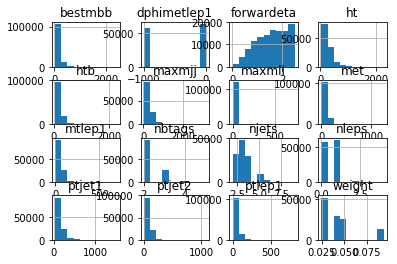

In [92]:
df = dfs["THQ"]
df[df.nbtags>=2].hist();

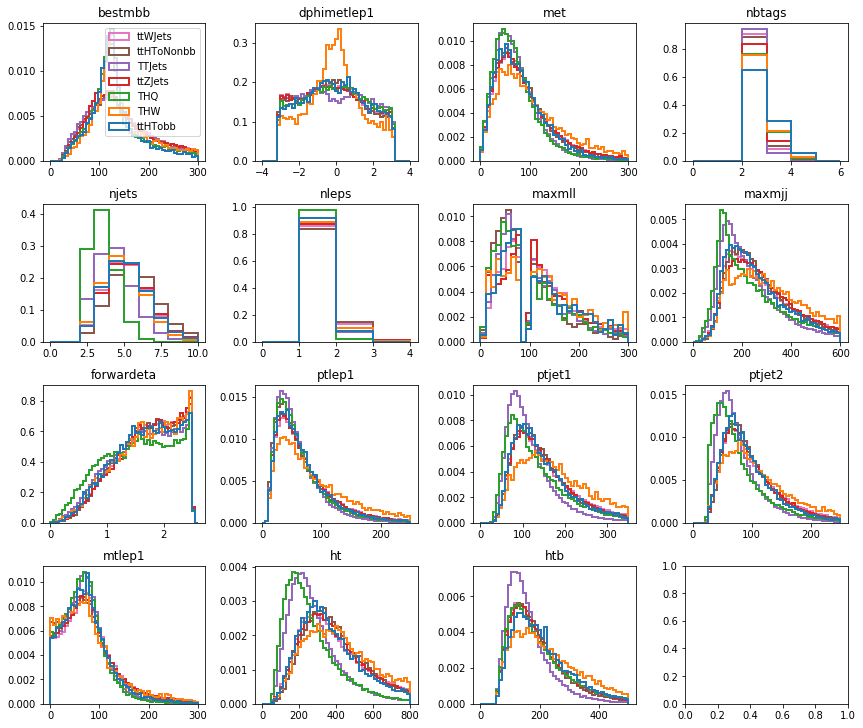

In [93]:
fig,axs = plt.subplots(4,4,figsize=(12,10),constrained_layout=True)
axs = (ax for ax in axs.flat)
for ivar,(var,bins) in enumerate(tqdm_notebook([
    ["bestmbb",np.linspace(0,300,50)],
    ["dphimetlep1",np.linspace(-4,4,50)],
    ["met",np.linspace(0,300,50)],
    ["nbtags",np.linspace(0,6,7)],
    ["njets",np.linspace(0,10,11)],
    ["nleps",np.linspace(0,4,5)],
    ["maxmll",np.linspace(0,300,30)],
    ["maxmjj",np.linspace(0,600,50)],
    ["forwardeta",np.linspace(0,2.6,50)],
    ["ptlep1",np.linspace(0,250,50)],
    ["ptjet1",np.linspace(0,350,50)],
    ["ptjet2",np.linspace(0,250,50)],
    ["mtlep1",np.linspace(0,300,50)],
    ["ht",np.linspace(0,800,50)],
    ["htb",np.linspace(0,500,50)],
])):
#     print var
    ax = next(axs)
#     procs = list(set(dfs.keys())-set(["TTJets"]))
    procs = dfs.keys()
    def sel(df):
        return (df.nbtags>=2) & (df.njets>=2) & (df.nleps >= 1) & (np.abs(df.maxmll-91.2)>10.)
    vals = [dfs[k][sel(dfs[k])][var] for k in procs]
    weights = [dfs[k][sel(dfs[k])]["weight"] for k in procs]
#     ax.hist(vals,bins=bins,weights=weights,stacked=False,alpha=1,histtype="step",label=procs,density=False,lw=2);
    ax.hist(vals,bins=bins,weights=weights,stacked=False,alpha=1,histtype="step",label=procs,density=True,lw=2);
    ax.set_title(var);
    if ivar == 0: ax.legend();